# Pre-matched data with auxiliary data



In [1]:
import modelskill as ms
import numpy as np
import pandas as pd
import mikeio

In [2]:
fn = "../tests/testdata/SW/eur_matched.dfs0"
mikeio.read(fn)

<mikeio.Dataset>
dims: (time:67)
time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00 (67 records)
geometry: GeometryUndefined()
items:
  0:  Hm0, model <Significant wave height> (meter)
  1:  Hm0, obs <Significant wave height> (meter)
  2:  Wind speed <Wind speed> (meter per sec)
  3:  Wind Direction <Wind Direction> (degree)

The function `from_matched()` takes a dataframe, a dfs0 or a mikeio.Dataset of already matched data and returns a Comparer object.

In [3]:
cmp = ms.from_matched(fn, obs_item=1, mod_items=0, aux_items=[2,3])
cmp.aux_names

('Wind speed', 'Wind Direction')

In [4]:
# NOTE: we rename data_vars to avoid spaces in names
cmp = cmp.rename({"Wind speed": "wind_speed", "Wind Direction": "wind_dir"})

In [5]:
cmp.aux_names

('wind_speed', 'wind_dir')

In [6]:
cmp

<Comparer>
Quantity: Significant wave height [meter]
Observation: Hm0, obs, n_points=67
 Model: Hm0, model, rmse=0.228
 Auxiliary: wind_speed
 Auxiliary: wind_dir

In [7]:
cmp.data

<xarray.Dataset>
Dimensions:      (time: 67)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
    x            float64 nan
    y            float64 nan
    z            float64 nan
Data variables:
    Observation  (time) float64 0.92 1.03 1.24 1.34 1.55 ... 3.24 3.23 3.36 3.23
    Hm0, model   (time) float64 1.43 1.655 1.789 1.834 ... 3.473 3.395 3.307
    wind_speed   (time) float64 9.754 11.06 11.42 10.93 ... 13.54 13.06 12.87
    wind_dir     (time) float64 327.4 331.5 333.3 330.2 ... 343.6 343.7 345.9
Attributes:
    name:                Hm0, obs
    gtype:               point
    modelskill_version:  1.0.b0

In [8]:
cmp.skill()

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
"Hm0, obs",67,0.052239,0.22824,0.222181,0.174851,0.968321,0.085898,0.929767


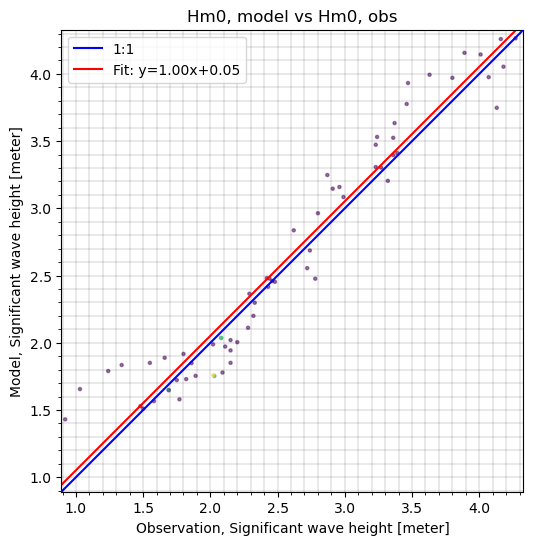

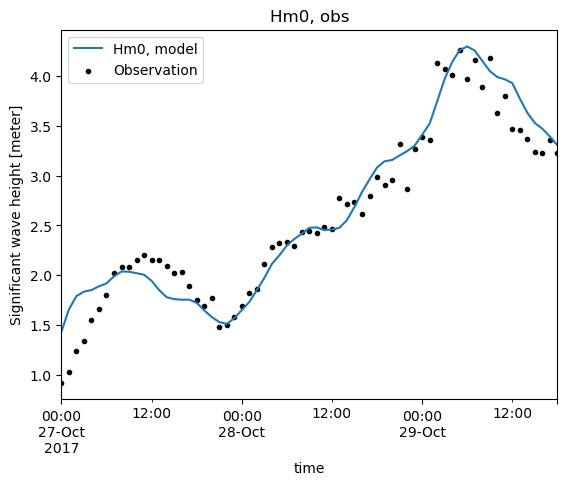

In [9]:
cmp.plot.scatter(quantiles=0, figsize=(6,6));
cmp.plot.timeseries();

## Filter 

Filter on auxiliary data using `query()` or `where()`. Below, we consider only wave data when the wind speed is above 15 m/s.

In [10]:
cmp.query("wind_speed > 15.0")

<Comparer>
Quantity: Significant wave height [meter]
Observation: Hm0, obs, n_points=19
 Model: Hm0, model, rmse=0.201
 Auxiliary: wind_speed
 Auxiliary: wind_dir

In [11]:
cmp2 = cmp.where(cmp.data.wind_speed>15.0)
cmp2

<Comparer>
Quantity: Significant wave height [meter]
Observation: Hm0, obs, n_points=19
 Model: Hm0, model, rmse=0.201
 Auxiliary: wind_speed
 Auxiliary: wind_dir

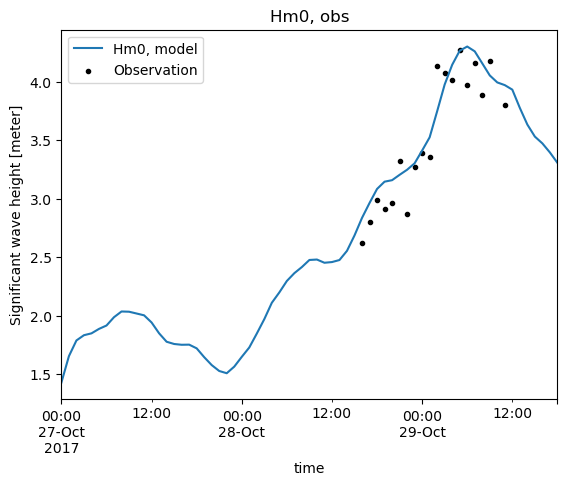

In [12]:
# notice that the model data is kept, but the observations are filtered
cmp2.plot.timeseries();

More auxiliary data can be added, e.g. as derived data from the original data. 

In [13]:
cmp.data["residual"] = cmp.data["Hm0, model"] - cmp.data["Observation"]

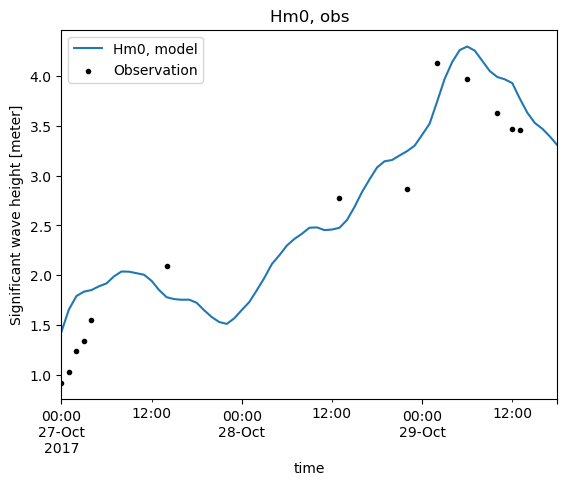

In [14]:
large_residuals = np.abs(cmp.data.residual)>0.3
cmp3 = cmp.where(large_residuals)
# cmp3.plot.scatter(figsize=(6,6));
cmp3.plot.timeseries();

In [15]:
cmp3.data.data_vars

Data variables:
    Observation  (time) float64 0.92 1.03 1.24 1.34 1.55 ... 3.97 3.63 3.47 3.46
    Hm0, model   (time) float64 1.43 1.655 1.789 1.834 ... 4.3 3.993 3.932 3.776
    wind_speed   (time) float64 9.754 11.06 11.42 10.93 ... 14.86 14.71 13.53
    wind_dir     (time) float64 327.4 331.5 333.3 330.2 ... 345.0 345.8 346.5
    residual     (time) float64 0.5101 0.6253 0.5495 ... 0.3634 0.4617 0.3159

In [16]:
cmp3.data.Observation.values

array([0.92000002, 1.02999997, 1.24000001, 1.34000003, 1.54999995,
       2.08999991, 2.77999997, 2.86999989, 4.13000011, 3.97000003,
       3.63000011, 3.47000003, 3.46000004])

## Aggregate

Let's split the data based on wind direction sector and aggregate the skill calculation of the significant wave height predition for each sector.

In [17]:
# Note: in this short example wind direction is between 274 and 353 degrees
df = cmp.data.wind_dir.to_dataframe()
cmp.data["windsector"] = pd.cut(df.wind_dir, [255, 285, 315, 345, 360], labels=["W", "WNW", "NNW", "N"])

In [18]:
ss = cmp.skill(by="windsector")
ss.style()

,observation,n,bias,rmse,urmse,mae,cc,si,r2
windsector,,,,,,,,,
N,"Hm0, obs",7,0.070,0.252,0.242,0.223,0.991,0.083,0.859
NNW,"Hm0, obs",28,0.116,0.285,0.261,0.231,0.970,0.103,0.928
W,"Hm0, obs",17,0.026,0.165,0.163,0.123,0.962,0.067,0.904
WNW,"Hm0, obs",15,-0.045,0.142,0.135,0.108,0.984,0.050,0.965


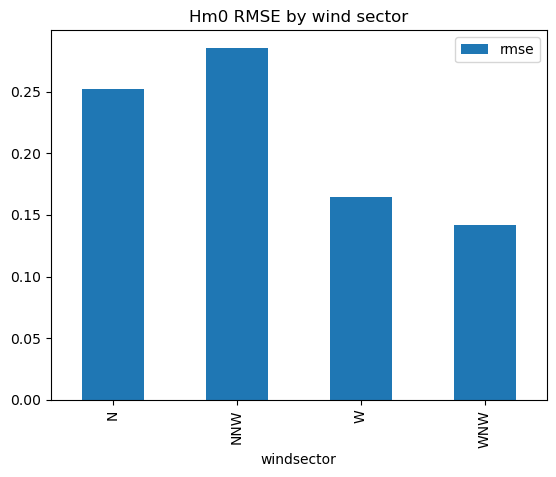

In [19]:
ss["rmse"].plot.bar(title="Hm0 RMSE by wind sector");

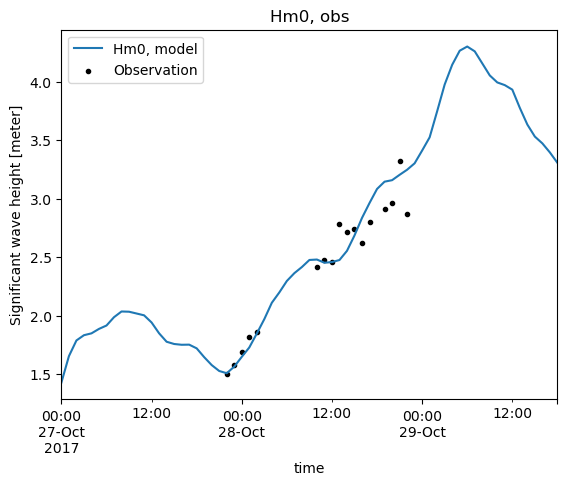

In [20]:
cmp.where(cmp.data.windsector=="W").plot.timeseries();